## Import Modules

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [ ]:
# from google.colab import drive

# # This will prompt for authorization.
# drive.mount('/content/drive')


## Load the Dataset

In [ ]:
BASE_DIR = '/content/drive/MyDrive/Colab Notebooks/ab_nhi/last_data'

In [ ]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    print(filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

In [ ]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'] = image_paths, age_labels
df.head()

image  age
0  /content/drive/MyDrive/Colab Notebooks/ab_nhi/...   19
1  /content/drive/MyDrive/Colab Notebooks/ab_nhi/...   45
2  /content/drive/MyDrive/Colab Notebooks/ab_nhi/...   32
3  /content/drive/MyDrive/Colab Notebooks/ab_nhi/...   29
4  /content/drive/MyDrive/Colab Notebooks/ab_nhi/...   12

In [ ]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

## Exploratory Data Analysis

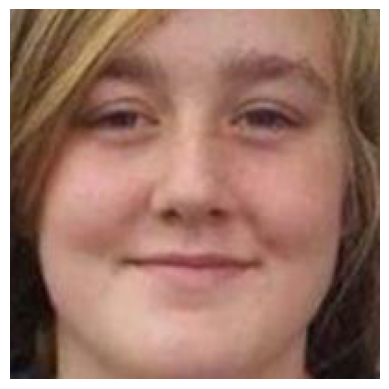

In [ ]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

In [ ]:
sns.distplot(df['age'])

<Axes: xlabel='age', ylabel='Density'>

In [ ]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} ")
    plt.axis('off')

## Feature Extraction

In [ ]:
from PIL import Image

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.LANCZOS)  # Use Image.LANCZOS for resizing
        img = np.array(img)
        features.append(img)
    return features

X = extract_features(df['image'])

  0%|          | 0/4150 [00:00<?, ?it/s]

In [ ]:
import numpy as np

# Convert the list of features (X) into a NumPy array
X = np.array(X)

# Now you can access the shape attribute
print(X.shape)


(4150, 128, 128)


In [ ]:
# normalize the images
X = X/255.0

In [ ]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [ ]:
input_shape = (128, 128, 1)

## Model Creation

In [ ]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.4) (dense_1)
dropout_2 = Dropout(0.4) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

In [ ]:
# # Data augmentation
# datagen = ImageDataGenerator(
#     rotation_range=10,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     vertical_flip=False,
#     fill_mode='nearest'
# )
# augmented_data = datagen.flow(x=X, y=y_age, batch_size=32)

In [ ]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
104/104 [==============================] - 15s 123ms/step - loss: 10.7255 - gender_out_loss: 0.0092 - age_out_loss: 10.7163 - gender_out_accuracy: 0.9919 - gender_out_mae: 0.0070 - age_out_accuracy: 0.0000e+00 - age_out_mae: 10.7163 - val_loss: 9.8456 - val_gender_out_loss: 1.5716e-11 - val_age_out_loss: 9.8456 - val_gender_out_accuracy: 1.0000 - val_gender_out_mae: 0.0000e+00 - val_age_out_accuracy: 0.0000e+00 - val_age_out_mae: 9.8456
Epoch 2/30
104/104 [==============================] - 12s 116ms/step - loss: 8.5558 - gender_out_loss: 5.0417e-07 - age_out_loss: 8.5558 - gender_out_accuracy: 1.0000 - gender_out_mae: 5.0391e-07 - age_out_accuracy: 0.0000e+00 - age_out_mae: 8.5558 - val_loss: 7.8087 - val_gender_out_loss: 1.8047e-11 - val_age_out_loss: 7.8087 - val_gender_out_accuracy: 1.0000 - val_gender_out_mae: 0.0000e+00 - val_age_out_accuracy: 0.0000e+00 - val_age_out_mae: 7.8087
Epoch 3/30
104/104 [==============================] - 12s 117ms/step - loss: 7.9832 - gende

In [ ]:
model.save('final_model.h5')

## Plot the Results

In [ ]:
# plot results for age
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Loss Graph')
plt.legend()
plt.show()

# Prediction with Test Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from sklearn.metrics import mean_absolute_error

# Assuming 'model' is your trained model and X, y_age are your data and labels.

original_ages = []
predicted_ages = []
indices = []

# Loop over 100 iterations
for _ in range(100):
    # Select a random index between 1 and 1000
    index = randint(1, 1000)
    indices.append(index)

    # Predict the age
    pred = model.predict(X[index].reshape(1, 128, 128, 1))
    pred_age = round(pred[1][0][0])

    # Store the actual and predicted ages
    actual_age = y_age[index]
    original_ages.append(actual_age)
    predicted_ages.append(pred_age)

# Calculate the Mean Absolute Error as a form of accuracy
mae = mean_absolute_error(original_ages, predicted_ages)
accuracy = 100 - (mae / max(y_age) * 100)  # Adjusting MAE to a more intuitive accuracy metric

# Print the accuracy
print(f"Model Accuracy (Adjusted MAE): {accuracy:.2f}%")

# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(indices, original_ages, color='blue', label='Original Ages', marker='o', alpha=0.7)
plt.scatter(indices, predicted_ages, color='red', label='Predicted Ages', marker='x', alpha=0.7)
plt.title('Comparison of Original and Predicted Ages Across Random Samples')
plt.xlabel('Sample Index')
plt.ylabel('Age')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



1/1 [==============================] - 0s 28ms/step
Model Accuracy (Adjusted MAE): 92.93%


Original Age: 41
1/1 [==============================] - 0s 29ms/step
Predicted Age: 42


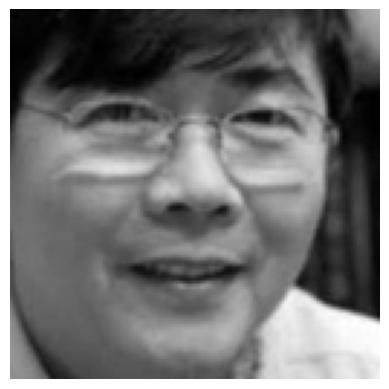

In [ ]:
image_index = 900
print("Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

In [ ]:
from base64 import b64decode, b64encode  # Add this import statement

from IPython.display import display, Javascript
from google.colab.output import eval_js
import cv2
import numpy as np
from PIL import Image
import io
import html
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import base64

# Load the pre-trained model
model = load_model('/content/drive/MyDrive/AI Project Files/best_for_live_cam (1).h5')

def js_to_image(js_reply):
    """
    Converts image data from JavaScript to OpenCV format.
    """
    image_bytes = b64decode(js_reply.split(',')[1])
    image = Image.open(io.BytesIO(image_bytes))
    return cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)

def prepare_image(img):
    """
    Pre-process the image to match the model's input requirements.
    """
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, (128, 128))
    img_array = img_to_array(img) / 255.0  # Normalize the image
    return np.expand_dims(img_array, axis=0)  # Reshape image to match model's input

def video_stream():
    js = Javascript('''
      var video;
      var div = null;
      var stream;
      var captureCanvas;
      var imgElement;
      var labelElement;

      var pendingResolve = null;
      var shutdown = false;

      function removeDom() {
        stream.getVideoTracks()[0].stop();
        video.remove();
        div.remove();
        video = null;
        div = null;
        stream = null;
        imgElement = null;
        captureCanvas = null;
        labelElement = null;
      }

      function onAnimationFrame() {
        if (!shutdown) {
          window.requestAnimationFrame(onAnimationFrame);
        }
        if (pendingResolve) {
          var result = "";
          if (!shutdown) {
            captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
            result = captureCanvas.toDataURL('image/jpeg', 0.8)
          }
          var lp = pendingResolve;
          pendingResolve = null;
          lp(result);
        }
      }

      async function createDom() {
        if (div !== null) {
          return stream;
        }

        div = document.createElement('div');
        div.style.border = '2px solid black';
        div.style.padding = '3px';
        div.style.width = '100%';
        div.style.maxWidth = '600px';
        document.body.appendChild(div);

        const modelOut = document.createElement('div');
        modelOut.innerHTML = "<span>Status:</span>";
        labelElement = document.createElement('span');
        labelElement.innerText = 'No data';
        labelElement.style.fontWeight = 'bold';
        modelOut.appendChild(labelElement);
        div.appendChild(modelOut);

        video = document.createElement('video');
        video.style.display = 'block';
        video.width = div.clientWidth - 6;
        video.setAttribute('playsinline', '');
        video.onclick = () => { shutdown = true; };
        stream = await navigator.mediaDevices.getUserMedia(
            {video: { facingMode: "environment"}});
        div.appendChild(video);

        imgElement = document.createElement('img');
        imgElement.style.position = 'absolute';
        imgElement.style.zIndex = 1;
        imgElement.onclick = () => { shutdown = true; };
        div.appendChild(imgElement);

        const instruction = document.createElement('div');
        instruction.innerHTML =
            '<span style="color: red; font-weight: bold;">' +
            'When finished, click here or on the video to stop this demo</span>';
        div.appendChild(instruction);
        instruction.onclick = () => { shutdown = true; };

        video.srcObject = stream;
        await video.play();

        captureCanvas = document.createElement('canvas');
        captureCanvas.width = 640; //video.videoWidth;
        captureCanvas.height = 480; //video.videoHeight;
        window.requestAnimationFrame(onAnimationFrame);

        return stream;
      }
      async function stream_frame(label, imgData) {
        if (shutdown) {
          removeDom();
          shutdown = false;
          return '';
        }

        var preCreate = Date.now();
        stream = await createDom();

        var preShow = Date.now();
        if (label != "") {
          labelElement.innerHTML = label;
        }

        if (imgData != "") {
          var videoRect = video.getClientRects()[0];
          imgElement.style.top = videoRect.top + "px";
          imgElement.style.left = videoRect.left + "px";
          imgElement.style.width = videoRect.width + "px";
          imgElement.style.height = videoRect.height + "px";
          imgElement.src = imgData;
        }

        var preCapture = Date.now();
        var result = await new Promise(function(resolve, reject) {
          pendingResolve = resolve;
        });
        shutdown = false;

        return {'create': preShow - preCreate,
                'show': preCapture - preShow,
                'capture': Date.now() - preCapture,
                'img': result};
      }
    ''')
    display(js)

def video_frame(label, bbox):
    data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
    return data

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
    """
    Params:
            js_reply: JavaScript object containing image from webcam
    Returns:
            img: OpenCV BGR image
    """
    # decode base64 image
    image_bytes = b64decode(js_reply.split(',')[1])
    # convert bytes to numpy array
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    # decode numpy array into OpenCV BGR image
    img = cv2.imdecode(jpg_as_np, flags=1)

    return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
    """
    Params:
            bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
    Returns:
          bytes: Base64 image byte string
    """
    # convert array into PIL image
    bbox_PIL = Image.fromarray(bbox_array, 'RGBA')
    iobuf = io.BytesIO()
    # format bbox into png for return
    bbox_PIL.save(iobuf, format='png')
    # format return string
    bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

    return bbox_bytes

# Start streaming video from webcam
video_stream()

label_html = ''
bbox = ''
count = 0
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
      face_img = gray[y:y+h, x:x+w]
      face_img = cv2.resize(face_img, (128, 128))
      face_img = face_img / 255.0
      face_img = np.expand_dims(np.expand_dims(face_img, -1), 0)
      prediction = model.predict(face_img, verbose=0)
      # pred_gender = 'Male' if round(prediction[0][0][0]) == 0 else 'Female'
      pred_age = round(prediction[1][0][0])

      if  10 <= pred_age <= 17:
         label = f"Age: 10-17"
      elif  18 <= pred_age <= 25:
         label = f"Age: 18-25"
      elif 26 <= pred_age <= 30:
         label = f"Age: 26-30"
      elif 30 <= pred_age <= 40:
         label = f"Age: 30-40"
      elif 41 <= pred_age <= 50:
         label = f"Age: 41-50"
      else :
         label = f"Age: Above 50"
      label_html = label
      cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0, 0), 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define a function to process the image
def prepare_image(image_path):
    img = load_img(image_path, color_mode='grayscale', target_size=(128, 128))
    img_array = img_to_array(img) / 255.0  # Normalize the image
    return np.expand_dims(img_array, axis=0)  # Reshape image to match model's input

# Load the model
model = load_model('/content/final_model.h5')

# Prepare a new image
new_image_path = '/content/50_1.png'
test_img = prepare_image(new_image_path)

# Predict using the model
prediction = model.predict(test_img)
pred_gender = 'Male' if round(prediction[0][0][0]) == 0 else 'Female'
pred_age = round(prediction[1][0][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)

# Display the image
plt.axis('off')
plt.imshow(test_img.reshape(128, 128), cmap='gray')
plt.show()